In [178]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

### 1. Bộ dữ liệu ARE Historical Data

In [179]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARE-Historical-Data.csv')
df1=df.reset_index()['Price']

In [180]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [181]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [182]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [183]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [184]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [185]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [186]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 47ms/step - loss: 0.0849 - val_loss: 0.3054
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0339 - val_loss: 0.0946
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.0735
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0112 - val_loss: 0.0540
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0305
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 3.2018e-04 - val_loss: 0.0095
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 2.8444e-04 - val_loss: 0.0073
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 2.5981e-04 - val_loss: 0.0

In [187]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 1ms/step


In [188]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [189]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [190]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 3.1431781300224912
Testing RMSE: 3.374549277134425
Testing MAE: 2.287613052837111
Validation MAE: 2.4531714197495407
Testing MAPE: 1.4033602123397737
Validation MAPE: 1.5041146399943748


In [191]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.2886826]
2
1 day input [0.28868261]
1 day output [[0.28905612]]
2 day input [0.28905612]


2 day output [[0.28943023]]
3 day input [0.28943023]
3 day output [[0.28980494]]
4 day input [0.28980494]
4 day output [[0.29018015]]
5 day input [0.29018015]
5 day output [[0.2905559]]
6 day input [0.29055589]
6 day output [[0.29093227]]
7 day input [0.29093227]
7 day output [[0.29130924]]
8 day input [0.29130924]
8 day output [[0.29168674]]
9 day input [0.29168674]
9 day output [[0.29206488]]
10 day input [0.29206488]
10 day output [[0.29244357]]
11 day input [0.29244357]
11 day output [[0.29282296]]
12 day input [0.29282296]
12 day output [[0.29320288]]
13 day input [0.29320288]
13 day output [[0.2935834]]
14 day input [0.29358339]
14 day output [[0.29396456]]
15 day input [0.29396456]
15 day output [[0.2943463]]
16 day input [0.2943463]
16 day output [[0.29472864]]
17 day input [0.29472864]
17 day output [[0.29511163]]
18 day input [0.29511163]
18 day output [[0.29549524]]
19 day input [0.29549524]
19 day output [[0.29587948]]
20 day input [0.29587948]
20 day output [[0.29626432]]


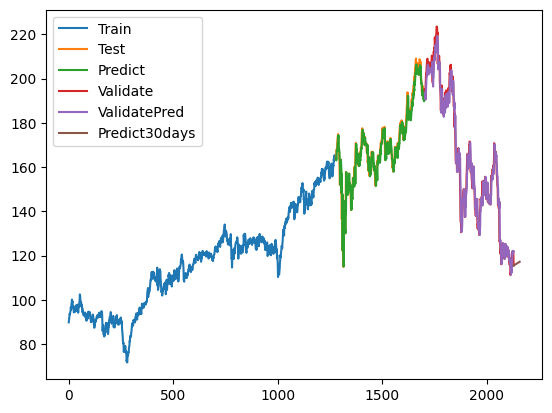

In [192]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 2. Bộ dữ liệu ARI Historical Data

In [193]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARI-Historical-Data.csv')
df1=df.reset_index()['Price']

In [194]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [195]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [196]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [197]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [198]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [199]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [200]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


20/20 [==============================] - 5s 46ms/step - loss: 0.6777 - val_loss: 0.1992
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.3836 - val_loss: 0.0373
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0397 - val_loss: 0.1007
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0457
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0604
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0555
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0559
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0561
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0537
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0545
Epoch 11/100
20/20 [

In [201]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 997us/step


In [202]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [203]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [204]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.9751242107796603
Testing RMSE: 1.292496845236143
Testing MAE: 0.9731788688461267
Validation MAE: 0.8395309891644642
Testing MAPE: 10.716357435197954
Validation MAPE: 7.7588637010285995


In [205]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.5191764]
2
1 day input [0.51917642]
1 day output [[0.56396234]]
2 day input [0.56396234]
2 day output [[0.5981925]]
3 day input [0.59819251]
3 day output [[0.6252279]]
4 day input [0.62522793]
4 day output [[0.6471249]]
5 day input [0.64712489]
5 day output [[0.66521686]]
6 day input [0.66521686]
6 day output [[0.6804083]]
7 day input [0.6804083]
7 day output [[0.69333553]]
8 day input [0.69333553]
8 day output [[0.70445985]]
9 day input [0.70445985]
9 day output [[0.7141249]]
10 day input [0.71412492]
10 day output [[0.72259116]]
11 day input [0.72259116]
11 day output [[0.7300604]]
12 day input [0.7300604]
12 day output [[0.73669124]]
13 day input [0.73669124]
13 day output [[0.7426106]]
14 day input [0.74261057]
14 day output [[0.74792045]]
15 day input [0.74792045]
15 day output [[0.7527045]]
16 day input [0.7527045]
16 day output [[0.7570318]]
17 day input [0.7570318]
17 day output [[0.7609597]]
18 day input [0.76095968]
18 day output [[0.7645363]]
19 day input [0.76453632]
19 

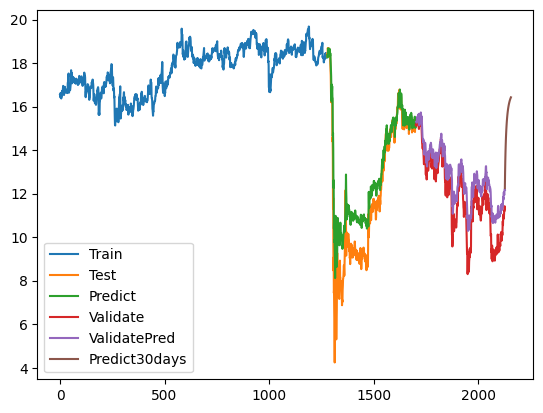

In [206]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 3. Bộ dữ liệu MAA Historical Data

In [207]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('MAA-Historical-Data.csv')
df1=df.reset_index()['Price']

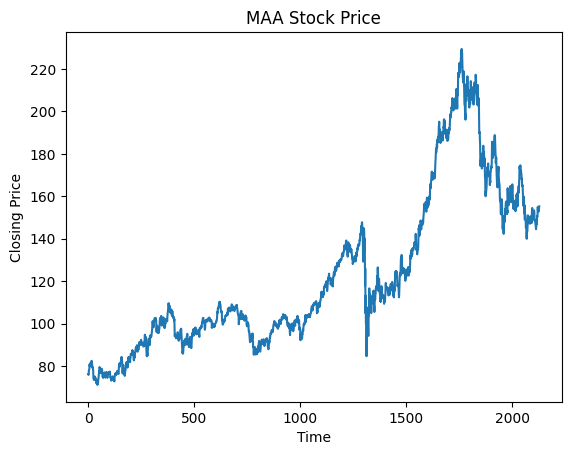

In [208]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('MAA Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

In [209]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [210]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [211]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [212]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [213]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [214]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [215]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 5s 41ms/step - loss: 0.0284 - val_loss: 0.1342
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0579
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0695
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0477
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0046 - val_loss: 0.0322
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0055
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 4.0108e-04 - val_loss: 0.0048
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 1.1466e-04 - val_loss: 0.0059
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 9.4669e-05 - val_loss: 0.0034
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 9.0832e-05 - val_loss:

In [216]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 997us/step


In [217]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [218]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [219]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 3.761710651517062
Testing RMSE: 3.002880423309863
Testing MAE: 2.05029990771138
Validation MAE: 2.8909324060776647
Testing MAPE: 1.5683242790817662
Validation MAPE: 1.5660007131650218


In [220]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.53103304]
2
1 day input [0.53103304]
1 day output [[0.53052443]]
2 day input [0.53052443]
2 day output [[0.53002965]]
3 day input [0.53002965]


3 day output [[0.52954835]]
4 day input [0.52954835]
4 day output [[0.52908003]]
5 day input [0.52908003]
5 day output [[0.52862436]]
6 day input [0.52862436]
6 day output [[0.5281809]]
7 day input [0.5281809]
7 day output [[0.5277493]]
8 day input [0.5277493]
8 day output [[0.5273292]]
9 day input [0.52732921]
9 day output [[0.52692026]]
10 day input [0.52692026]
10 day output [[0.52652216]]
11 day input [0.52652216]
11 day output [[0.52613455]]
12 day input [0.52613455]
12 day output [[0.525757]]
13 day input [0.52575701]
13 day output [[0.5253893]]
14 day input [0.52538931]
14 day output [[0.5250313]]
15 day input [0.52503133]
15 day output [[0.52468264]]
16 day input [0.52468264]
16 day output [[0.5243431]]
17 day input [0.52434307]
17 day output [[0.52401215]]
18 day input [0.52401215]
18 day output [[0.5236898]]
19 day input [0.52368981]
19 day output [[0.52337575]]
20 day input [0.52337575]
20 day output [[0.5230698]]
21 day input [0.5230698]
21 day output [[0.52277154]]
22 day 

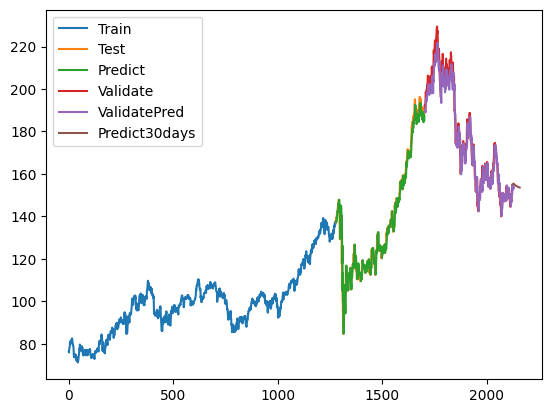

In [221]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()